In [166]:
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

*1. Загрузка данных*

In [47]:
# Загрузка датасета
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [48]:
# Изучим исходные данные
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [49]:
print(train_dataset.data.shape)
print(train_dataset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [50]:
print(test_dataset.data.shape)
print(test_dataset.targets.shape)

torch.Size([10000, 28, 28])
torch.Size([10000])


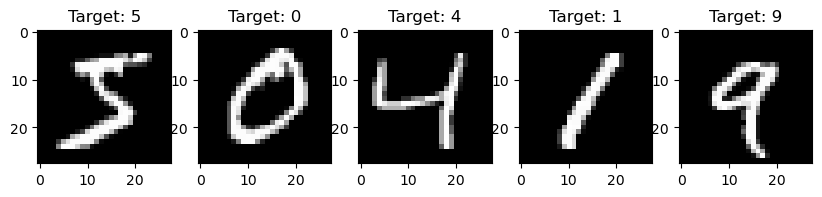

In [51]:
# Посмотрим на сами данные
fig, axes = plt.subplots(1, 5, figsize = (10, 3))

# id изображения, само изображения, целевая переменная
for ax, image, label in zip(axes, train_dataset.data, train_dataset.targets):

    ax.imshow(image, cmap = 'gray')
    # укажем, какой цифре соответствует изображение
    ax.set_title(f'Target: {label}')

2. *Нормализация данных*

In [52]:
# Разделим исходные данные
X_train, y_train = train_dataset.data.numpy(), train_dataset.targets.numpy()
X_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy()

In [53]:
# Приведём распредение данных к интервалу [-1, 1]
X_train = 2. * (X_train - np.min(X_train)) / np.ptp(X_train) - 1
X_test = 2. * (X_test - np.min(X_test)) / np.ptp(X_test) - 1

In [54]:
# Вытянем изображения в один вектор
X_train = X_train.reshape((-1, 784))
X_test = X_test.reshape((-1, 784))

# посмотрим на результат
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [94]:
# Посмотим на итог нормализации
# Возмём первое изображение [0] и пиксели с 200 по 209
X_train[0][200:210]

array([-1.        , -1.        , -1.        , -0.61568627,  0.86666667,
        0.98431373,  0.98431373,  0.98431373,  0.98431373,  0.98431373])

In [95]:
# Преобразование в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

*3. Конфигурация Многослойного Перцептрона* 

* Создадим многослойный Перцептрон:
* Входной слой: 64 наблюдения * 784 признака
* 2 скрытых слоя по 64 нейрона - функция активации: ReLu
* Выходной слой: 10 неиронов, по одной а каждую цифру - функция активации: SoftMax (включено в CrossEntropyLoss)

In [177]:
# Определение модели
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # Инициализация весов Glorot Uniform
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [181]:
# Выберем размер выборки
epochs = 15
batch_sizes = [8, 16, 32, 48, 64, 90, 128, 150]

*4. Обучение*

In [179]:
test_results = defaultdict(list)

for size_idx, batch_size in enumerate(batch_sizes):
    # Обновим загрузчик данных
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Инициализация и настройка модели
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for b, (batch, labels) in enumerate(train_loader):
            
            # Прямой проход
            predictions = model(batch)
            loss = criterion(predictions, labels)
            
            # Обратный проход
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # Считаем результат
            running_loss += loss.item()
            predicted = torch.max(predictions.data, 1)[1]
            total += labels.size(0)
            batch_correct = (predicted == labels).sum().item()
            correct += batch_correct
            
            if b % 100 == 0 and b != 0:
                print(f'Batch size {batch_size}, Epoch: {epoch} Batch: {b} [{batch_size * b:6}/60000] Train loss: {loss.item():10.8f} Train accuracy: {batch_correct / batch_size:7.4f}')
        
        print(f'\nBatch size {batch_size}, Epoch {epoch} Result, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}, time: {time.time() - start_time:.2} sec')
    
        # Оценка модели на тестовых данных
        with torch.no_grad():
            predictions = model(X_test_tensor)
            predicted = torch.max(predictions.data, 1)[1]
            correct = (predicted == y_test_tensor).sum().item()
            accuracy = correct / y_test_tensor.size(0)
            
            # Запоминаем точность для тестовой выборки для эпохи
            test_results[batch_size].append(accuracy)
            print(f'Batch size {batch_size}, Epoch {epoch} Test Accuracy: {accuracy:.4f}\n')

Batch size 8, Epoch: 1 Batch: 100 [   800/60000] Train loss: 2.47198677 Train accuracy:  0.1250
Batch size 8, Epoch: 1 Batch: 200 [  1600/60000] Train loss: 1.88255024 Train accuracy:  0.2500
Batch size 8, Epoch: 1 Batch: 300 [  2400/60000] Train loss: 1.35846722 Train accuracy:  0.5000
Batch size 8, Epoch: 1 Batch: 400 [  3200/60000] Train loss: 0.35635900 Train accuracy:  0.8750
Batch size 8, Epoch: 1 Batch: 500 [  4000/60000] Train loss: 0.55652261 Train accuracy:  0.8750
Batch size 8, Epoch: 1 Batch: 600 [  4800/60000] Train loss: 0.71775633 Train accuracy:  0.8750
Batch size 8, Epoch: 1 Batch: 700 [  5600/60000] Train loss: 0.99507892 Train accuracy:  0.7500
Batch size 8, Epoch: 1 Batch: 800 [  6400/60000] Train loss: 1.19452119 Train accuracy:  0.6250
Batch size 8, Epoch: 1 Batch: 900 [  7200/60000] Train loss: 0.37286559 Train accuracy:  0.8750
Batch size 8, Epoch: 1 Batch: 1000 [  8000/60000] Train loss: 2.56154299 Train accuracy:  0.2500
Batch size 8, Epoch: 1 Batch: 1100 [  8

*5. Прогноз*

In [146]:
# Прогноз для последних 10 изображений
with torch.no_grad():
    last_10 = X_test_tensor[-10:]
    predictions = model(last_10)
    _, predicted = torch.max(predictions, 1)
    print("Pred labels: ", predicted.numpy())
    print("True labels: ", y_test_tensor.numpy()[-10:])

Pred labels:  [7 8 9 0 1 2 3 4 5 6]
True labels:  [7 8 9 0 1 2 3 4 5 6]


Визуализация результатов экспериментов

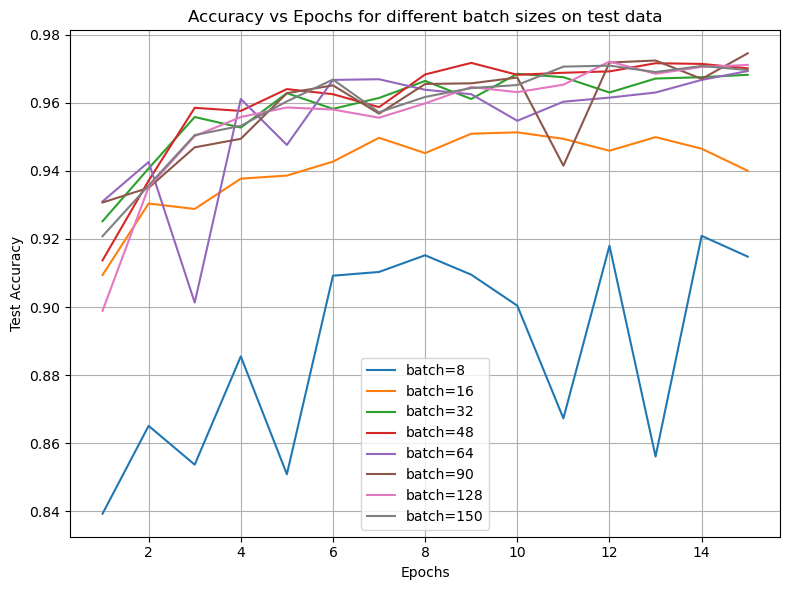

In [193]:
# График 1: Зависимость точности от эпох для разных batch_size на тестовых данных
plt.figure(figsize=(8, 6))
for batch_size in batch_sizes:
    plt.plot(range(1, epochs + 1), test_results[batch_size], label=f'batch={batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs Epochs for different batch sizes on test data')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

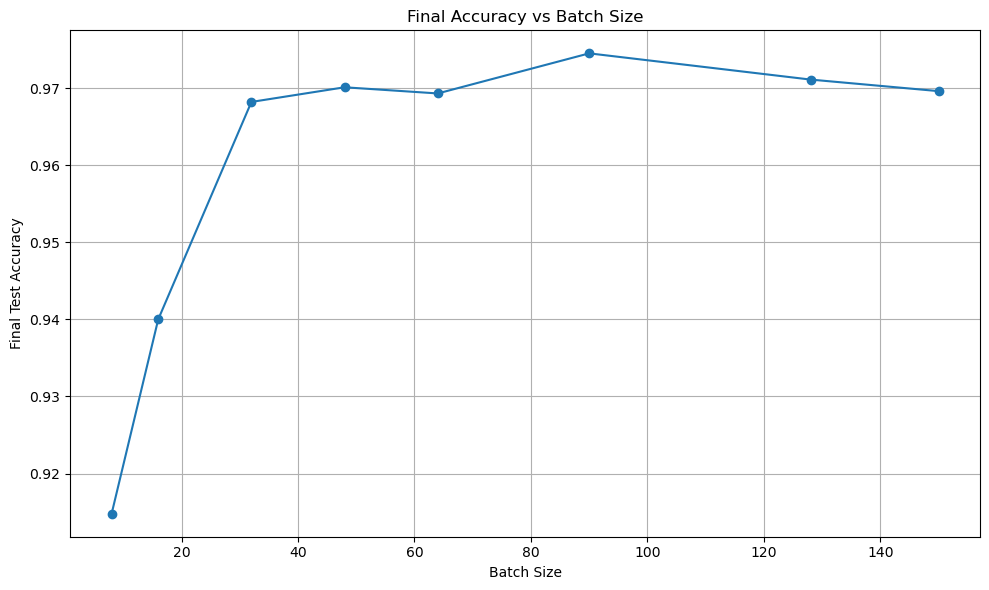

In [194]:
# График 2: Зависимость конечной точности от размера батча
plt.figure(figsize=(10, 6))
final_accuracies = [test_results[bs][-1] for bs in batch_sizes]
plt.plot(batch_sizes, final_accuracies, 'o-')
plt.xlabel('Batch Size')
plt.ylabel('Final Test Accuracy')
plt.title('Final Accuracy vs Batch Size')
plt.grid()

plt.tight_layout()
plt.show()

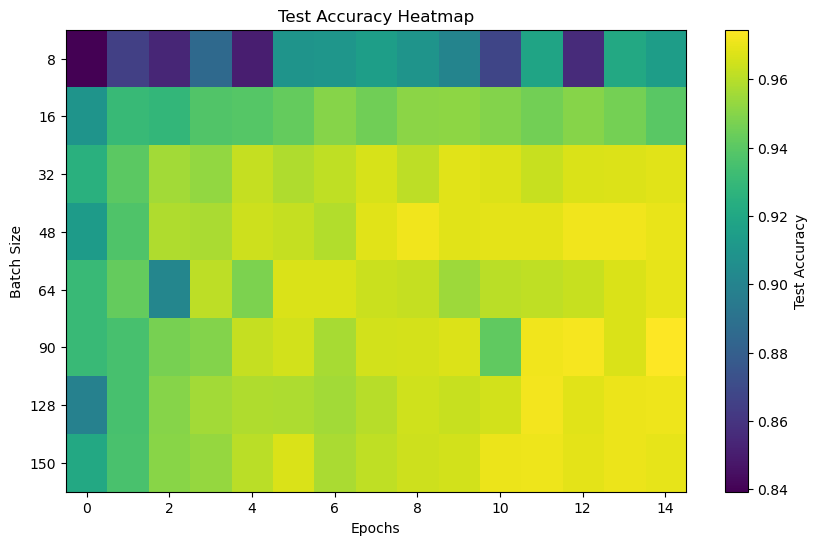

In [195]:
# График 3: Тепловая карта точности по эпохам и батчам
plt.figure(figsize=(10, 6))
accuracy_matrix = np.array([test_results[bs] for bs in batch_sizes])
plt.imshow(accuracy_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Test Accuracy')
plt.yticks(range(len(batch_sizes)), batch_sizes)
plt.xlabel('Epochs')
plt.ylabel('Batch Size')
plt.title('Test Accuracy Heatmap')
plt.show()

*Визуализация обучения с помощью t-SNE*

1. Возьмем активации с последнего слоя перед классификацией

In [196]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Уменьшим выборку для скорости обочения
vis_indices = np.random.choice(len(X_train), 1000, replace=False)
X_vis = X_train_tensor[vis_indices]
y_vis = y_train[vis_indices]

In [218]:
# Определение модели
class MLPWithFeatures(nn.Module):
    def __init__(self):
        super(MLPWithFeatures, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # Инициализация весов Glorot Uniform
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
    
    # Возьмем активации с последнего слоя перед классификацией
    def forward(self, x, return_features=False):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        if return_features:
            return x
        return self.fc3(x)

In [219]:
# Визуализация с t-SNE
def visualize_tsne(model, epoch):
    model.eval()
    with torch.no_grad():
        features = model(X_vis, return_features=True).numpy()
    
    # Применяем t-SNE
    tsne = TSNE(n_components=2, perplexity=30)
    features_2d = tsne.fit_transform(features)
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_vis, 
                         cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Digit Class')
    plt.title(f't-SNE visualization (Epoch {epoch})')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

In [220]:
# Инициализация модели
model = MLPWithFeatures()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

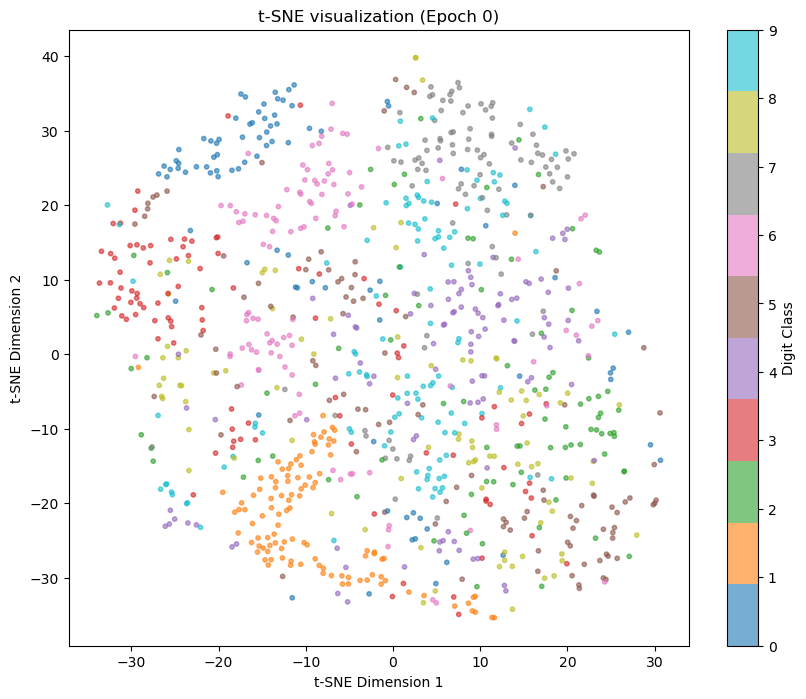

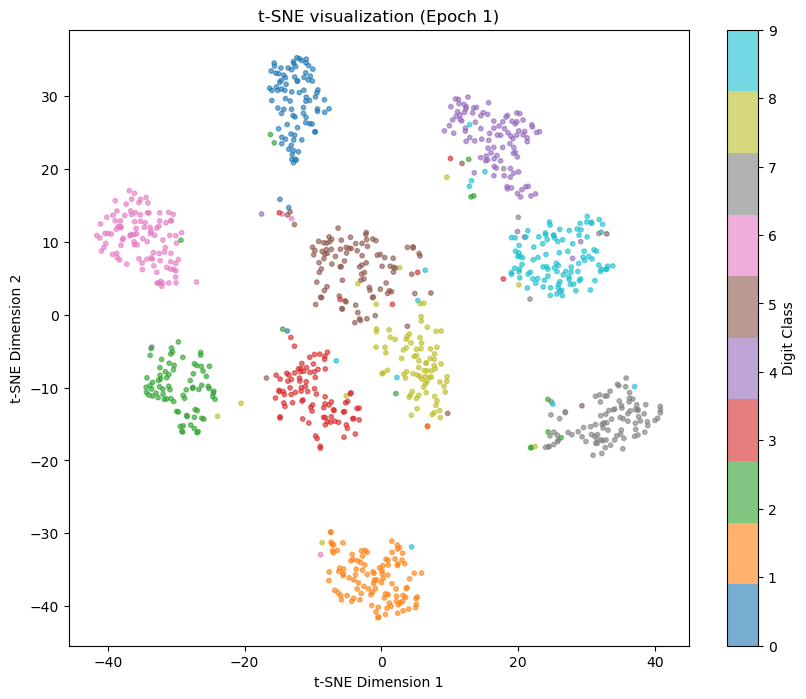

KeyboardInterrupt: 

In [221]:
# Обучение
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=90, shuffle=True)

visualize_tsne(model, 0)
for epoch in range(1, 51):
    model.train()
    for batch, labels in train_loader:
        optimizer.zero_grad()
        predicted = model(batch)
        loss = criterion(predicted, labels)
        loss.backward()
        optimizer.step()
    
    # Визуализация каждой 10-й эпохи
    if epoch % 10 == 0 or epoch == 1:
        visualize_tsne(model, epoch)